In [1]:
from IPython.core.display import display, HTML, Markdown

display(HTML("<style>.rendered_html { font-size: 17px; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

def printmd(string):
    display(Markdown(string))

import pandas as pd
import pybt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import subprocess
from cpymad.madx import Madx

plt.ion()
%matplotlib inline


try:
    import pybt
except:
    !kinit
    !pip install --user git+https://gitlab.cern.ch/abt-optics-and-code-repository/simulation-codes/pybt.git
    import pybt

# Madx simple line

In [7]:
mqk, mql, length = 1.0, 0.1, 5.3

madx = Madx()
madx.beam(particle='proton', pc=1000)

madx.command.sequence.clone('S1', l='{:10.6e}'.format(length))
madx.elements.marker.clone('s1start', at=0)
madx.command.endsequence()

madx.command.quadrupole.clone('QF', l=mql, k1=mqk)
madx.command.quadrupole.clone('QD', l=mql, k1=-mqk)
madx.command.rbend.clone('dip', l=0.1, angle=10e-3)



  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2020.06.23 09:50:01      +
  ++++++++++++++++++++++++++++++++++++++++++++


dip: rbend, l=0.1, angle=0.01;

In [8]:
madx.command.seqedit(sequence='S1')
madx.command.install(element='QF1', class_='QF', at='{:10.6e}'.format(mql/2))
madx.command.install(element='B1', class_='dip', at=mql+0.1/2)
madx.command.install(element='QD1', class_='QD', at='{:10.6e}'.format(length/2-mql/2))
madx.command.endedit()


++++++ info: seqedit - number of elements installed:  3
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

In [9]:
madx.use(sequence='s1')
madx.select(flag='interpolate', step=0.05)
madx.select(flag='twiss', full=True, column=['N1', 'apertype', 'aper_1', 'aper_2', 'aper_3', 'aper_4', 'apoff_1', 'apoff_2', 'aptol_1', 'aptol_2', 'aptol_3'])
twiss = madx.twiss().dframe()
twiss[['name', 'keyword', 's', 'betx', 'alfx', 'dx', 'dpx', 'bety', 'alfy', 'dy', 'dpy']]


enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
       5.300000208                 -0     0.001640076788        24.69266184 

                q1                dq1            betxmax              dxmax 
     0.04173114611      -0.0418147272        23.09870734       0.8729668285 

             dxrms             xcomax             xcorms                 q2 
        0.82442403                  0                  0       0.0431351058 

               dq2            betymax              dymax              dyrms 
    -0.04306814905        22.33825403                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

name     keyword         s       betx      alfx        dx  \
#s          s1$start:1      marker  0.000000  23.044975 -1.112397  0.872190   
s1start      s1start:1      marker  0.000000  23.044975 -1.112397  0.872190   
qf1              qf1:1  quadrupole  0.050000  23.098707  0.038643  0.872967   
qf1              qf1:1  quadrupole  0.100000  23.037259  1.189297  0.871562   
b1                b1:1       rbend  0.150000  22.919166  1.184057  0.869203   
...                ...         ...       ...        ...       ...       ...   
drift_1[0]   drift_1:0       drift  5.147116  22.707107 -1.097553  0.866478   
drift_1[0]   drift_1:0       drift  5.198077  22.819226 -1.102501  0.868382   
drift_1[0]   drift_1:0       drift  5.249039  22.931848 -1.107449  0.870286   
drift_1[0]   drift_1:0       drift  5.300000  23.044975 -1.112397  0.872190   
#e            s1$end:1      marker  5.300000  23.044975 -1.112397  0.872190   

                 dpx       bety      alfy   dy  dpy  
#s          0.037361  17.261800  0.819674  0.0 -0.0  
s1start     0.037361  17.261800  0.819674  0.0 -0.0  
qf1        -0.006277  17.223129 -0.045604  0.0  0.0  
qf1        -0.049899  17.270936 -0.911339  0.0  0.0  
b1         -0.044899  17.361470 -0.907957  0.0  0.0  
...              ...        ...       ...  ...  ...  
drift_1[0]  0.037361  17.514695  0.834482  0.0  0.0  
drift_1[0]  0.037361  17.429894  0.829546  0.0  0.0  
drift_1[0]  0.037361  17.345595  0.824610  0.0  0.0  
drift_1[0]  0.037361  17.261800  0.819674  0.0  0.0  
#e          0.037361  17.261800  0.819674  0.0  0.0  

[107 rows x 11 columns]

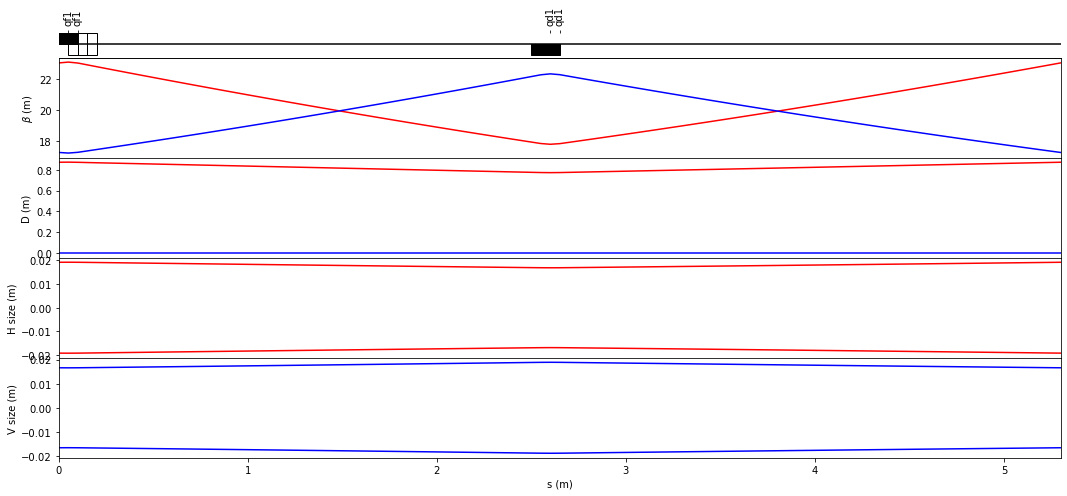

In [10]:
fig = plt.figure(figsize=(15,7))
pybt.tools.plotters.draw_optics({'ex':1e-6, 'ey':1e-6, 'sige':1e-4*0}, twiss, fig, ['quadrupole'])


# Simple straight 7 cells FODO line

In [11]:
ncells = 7

madx.command.sequence.clone('S1', l='{:10.6e}'.format(length*ncells))
madx.elements.marker.clone('s1start', at=0)
madx.command.endsequence()

madx.command.quadrupole.clone('QF', l=mql, k1=mqk)
madx.command.quadrupole.clone('QD', l=mql, k1=-mqk)

madx.command.seqedit(sequence='S1')
for cell in range(ncells):
    madx.command.install(element='QF1', class_='QF', at='{:10.6e}'.format(mql/2 + cell*length))
    madx.command.install(element='QD1', class_='QD', at='{:10.6e}'.format(length/2 - mql/2 + cell*length))
madx.command.endedit()



++++++ info: obsolete option 'full'  ignored on 'select'
++++++ warning: implicit element re-definition ignored: s1start
++++++ info: element redefined: qf
++++++ info: element redefined: qd
++++++ warning: implicit element re-definition ignored: qf1
++++++ warning: implicit element re-definition ignored: qd1
++++++ warning: implicit element re-definition ignored: qf1
++++++ warning: implicit element re-definition ignored: qd1
++++++ warning: implicit element re-definition ignored: qf1
++++++ warning: implicit element re-definition ignored: qd1
++++++ warning: implicit element re-definition ignored: qf1
++++++ warning: implicit element re-definition ignored: qd1
++++++ warning: implicit element re-definition ignored: qf1
++++++ warning: implicit element re-definition ignored: qd1
++++++ warning: implicit element re-definition ignored: qf1
++++++ warning: implicit element re-definition ignored: qd1
++++++ warning: implicit element re-definition ignored: qf1
++++++ warning: implicit elem

True

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
              37.1                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2921181079       -0.293803131        23.09870793                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2921181079 

               dq2            betymax              dymax              dyrms 
      -0.293803131        23.09870793                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

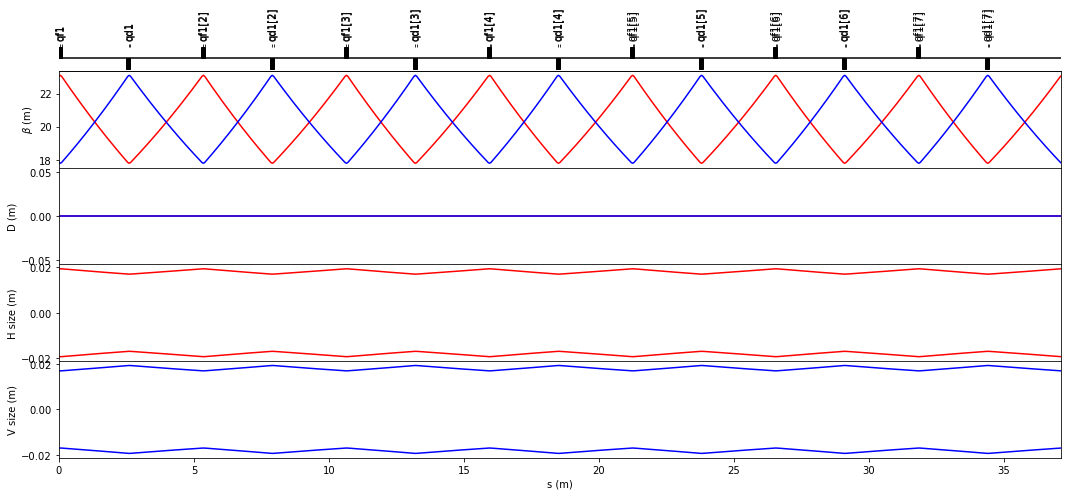

In [12]:
madx.use(sequence='s1')
madx.select(flag='twiss', full=True, 
            column=['N1', 'apertype', 'aper_1', 'aper_2', 'aper_3', 'aper_4', 'apoff_1', 'apoff_2', 'aptol_1', 'aptol_2', 'aptol_3'])
twiss = madx.twiss().dframe()

fig = plt.figure(figsize=(15,7))
pybt.tools.plotters.draw_optics({'ex':1e-6, 'ey':1e-6, 'sige':1e-4}, twiss, fig, ['quadrupole'])

print(dict(twiss.iloc[0][['betx', 'alfx', 'dx', 'dpx', 'bety', 'alfy', 'dy', 'dpy']]))
print(dict(twiss.iloc[-1][['betx', 'alfx', 'dx', 'dpx', 'bety', 'alfy', 'dy', 'dpy']]))


In [13]:
madx.survey()
survey = madx.table.survey.dframe()

print(dict(survey.iloc[0][['x', 'y', 'z', 'theta', 'phi', 'psi']]))
print(dict(survey.iloc[-1][['x', 'y', 'z', 'theta', 'phi', 'psi']]))


survey

++++++ info: obsolete option 'full'  ignored on 'select'
{'x': 0.0, 'y': 0.0, 'z': 0.0, 'theta': 0.0, 'phi': 0.0, 'psi': 0.0}
{'x': 0.0, 'y': 0.0, 'z': 37.1, 'theta': 0.0, 'phi': 0.0, 'psi': 0.0}


name     keyword      s     l  angle    x    y      z  \
#s           s1$start:1      marker   0.00  0.00    0.0  0.0  0.0   0.00   
s1start       s1start:1      marker   0.00  0.00    0.0  0.0  0.0   0.00   
qf1               qf1:1  quadrupole   0.10  0.10    0.0  0.0  0.0   0.10   
drift_0[0]    drift_0:0       drift   2.55  2.45    0.0  0.0  0.0   2.55   
qd1               qd1:1  quadrupole   2.65  0.10    0.0  0.0  0.0   2.65   
drift_1[0]    drift_1:0       drift   5.30  2.65    0.0  0.0  0.0   5.30   
qf1[2]            qf1:2  quadrupole   5.40  0.10    0.0  0.0  0.0   5.40   
drift_2[0]    drift_2:0       drift   7.85  2.45    0.0  0.0  0.0   7.85   
qd1[2]            qd1:2  quadrupole   7.95  0.10    0.0  0.0  0.0   7.95   
drift_3[0]    drift_3:0       drift  10.60  2.65    0.0  0.0  0.0  10.60   
qf1[3]            qf1:3  quadrupole  10.70  0.10    0.0  0.0  0.0  10.70   
drift_4[0]    drift_4:0       drift  13.15  2.45    0.0  0.0  0.0  13.15   
qd1[3]            qd1:3  quadrupole  13.25  0.10    0.0  0.0  0.0  13.25   
drift_5[0]    drift_5:0       drift  15.90  2.65    0.0  0.0  0.0  15.90   
qf1[4]            qf1:4  quadrupole  16.00  0.10    0.0  0.0  0.0  16.00   
drift_6[0]    drift_6:0       drift  18.45  2.45    0.0  0.0  0.0  18.45   
qd1[4]            qd1:4  quadrupole  18.55  0.10    0.0  0.0  0.0  18.55   
drift_7[0]    drift_7:0       drift  21.20  2.65    0.0  0.0  0.0  21.20   
qf1[5]            qf1:5  quadrupole  21.30  0.10    0.0  0.0  0.0  21.30   
drift_8[0]    drift_8:0       drift  23.75  2.45    0.0  0.0  0.0  23.75   
qd1[5]            qd1:5  quadrupole  23.85  0.10    0.0  0.0  0.0  23.85   
drift_9[0]    drift_9:0       drift  26.50  2.65    0.0  0.0  0.0  26.50   
qf1[6]            qf1:6  quadrupole  26.60  0.10    0.0  0.0  0.0  26.60   
drift_10[0]  drift_10:0       drift  29.05  2.45    0.0  0.0  0.0  29.05   
qd1[6]            qd1:6  quadrupole  29.15  0.10    0.0  0.0  0.0  29.15   
drift_11[0]  drift_11:0       drift  31.80  2.65    0.0  0.0  0.0  31.80   
qf1[7]            qf1:7  quadrupole  31.90  0.10    0.0  0.0  0.0  31.90   
drift_12[0]  drift_12:0       drift  34.35  2.45    0.0  0.0  0.0  34.35   
qd1[7]            qd1:7  quadrupole  34.45  0.10    0.0  0.0  0.0  34.45   
drift_13[0]  drift_13:0       drift  37.10  2.65    0.0  0.0  0.0  37.10   
#e             s1$end:1      marker  37.10  0.00    0.0  0.0  0.0  37.10   

             theta  phi  psi  globaltilt  slot_id  assembly_id  mech_sep  \
#s             0.0  0.0  0.0         0.0      0.0          0.0       0.0   
s1start        0.0  0.0  0.0         0.0      0.0          0.0       0.0   
qf1            0.0  0.0  0.0         0.0      0.0          0.0       0.0   
drift_0[0]     0.0  0.0  0.0         0.0      0.0          0.0       0.0   
qd1            0.0  0.0  0.0         0.0      0.0          0.0       0.0   
drift_1[0]     0.0  0.0  0.0         0.0      0.0          0.0       0.0   
qf1[2]         0.0  0.0  0.0         0.0      0.0          0.0       0.0   
drift_2[0]     0.0  0.0  0.0         0.0      0.0          0.0       0.0   
qd1[2]         0.0  0.0  0.0         0.0      0.0          0.0       0.0   
drift_3[0]     0.0  0.0  0.0         0.0      0.0          0.0       0.0   
qf1[3]         0.0  0.0  0.0         0.0      0.0          0.0       0.0   
drift_4[0]     0.0  0.0  0.0         0.0      0.0          0.0       0.0   
qd1[3]         0.0  0.0  0.0         0.0      0.0          0.0       0.0   
drift_5[0]     0.0  0.0  0.0         0.0      0.0          0.0       0.0   
qf1[4]         0.0  0.0  0.0         0.0      0.0          0.0       0.0   
drift_6[0]     0.0  0.0  0.0         0.0      0.0          0.0       0.0   
qd1[4]         0.0  0.0  0.0         0.0      0.0          0.0       0.0   
drift_7[0]     0.0  0.0  0.0         0.0      0.0          0.0       0.0   
qf1[5]         0.0  0.0  0.0         0.0      0.0          0.0       0.0   
drift_8[0]     0.0  0.0  0.0         0.0      0.0          0.0    

## And twiss with initial parameters

In [14]:
madx.twiss(betx= 23.044975429346476, alfx= -1.112397251341803, bety= 17.831081773677475, alfy= 0.8551097885332961, range='#s/qf1[3]').dframe()

enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
              10.7                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
     0.08415191122                  0        23.09870793                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0      0.08435618656 

               dq2            betymax              dymax              dyrms 
                 0        23.09870793                  0                  0 

            ycomax             ycorms             deltap            synch_1 


name     keyword          s       betx      alfx       mux  \
#s          s1$start:1      marker   0.000000  23.044975 -1.112397  0.000000   
s1start      s1start:1      marker   0.000000  23.044975 -1.112397  0.000000   
qf1              qf1:1  quadrupole   0.050000  23.098708  0.038643  0.000345   
qf1              qf1:1  quadrupole   0.100000  23.037260  1.189297  0.000690   
drift_0[0]   drift_0:0       drift   0.150000  22.918592  1.184057  0.001036   
...                ...         ...        ...        ...       ...       ...   
drift_3[0]   drift_3:0       drift  10.498077  22.819226 -1.102502  0.082755   
drift_3[0]   drift_3:0       drift  10.549038  22.931849 -1.107449  0.083109   
drift_3[0]   drift_3:0       drift  10.600000  23.044975 -1.112397  0.083462   
qf1[3]           qf1:3  quadrupole  10.650000  23.098708  0.038643  0.083807   
qf1[3]           qf1:3  quadrupole  10.700000  23.037260  1.189297  0.084152   

                 bety      alfy       muy    x  ...  apertype  aper_1  aper_2  \
#s          17.831082  0.855110  0.000000  0.0  ...    circle     0.0     0.0   
s1start     17.831082  0.855110  0.000000  0.0  ...    circle     0.0     0.0   
qf1         17.790286 -0.038514  0.000447  0.0  ...    circle     0.0     0.0   
qf1         17.838798 -0.932524  0.000894  0.0  ...    circle     0.0     0.0   
drift_0[0]  17.932312 -0.937764  0.001339  0.0  ...      none     0.0     0.0   
...               ...       ...       ...  ...  ...       ...     ...     ...   
drift_3[0]  18.006401  0.865005  0.082557  0.0  ...      none     0.0     0.0   
drift_3[0]  17.918489  0.860058  0.083009  0.0  ...      none     0.0     0.0   
drift_3[0]  17.831082  0.855110  0.083462  0.0  ...      none     0.0     0.0   
qf1[3]      17.790286 -0.038514  0.083909  0.0  ...    circle     0.0     0.0   
qf1[3]      17.838798 -0.932524  0.084356  0.0  ...    circle     0.0     0.0   

            aper_3  aper_4  apoff_1  apoff_2  aptol_1  aptol_2  aptol_3  
#s             0.0     0.0      0.0      0.0      0.0      0.0      0.0  
s1start        0.0     0.0      0.0      0.0      0.0      0.0      0.0  
qf1            0.0     0.0      0.0      0.0      0.0      0.0      0.0  
qf1            0.0     0.0      0.0      0.0      0.0      0.0      0.0  
drift_0[0]     0.0     0.0      0.0      0.0      0.0      0.0      0.0  
...            ...     ...      ...      ...      ...      ...      ...  
drift_3[0]     0.0     0.0      0.0      0.0      0.0      0.0      0.0  
drift_3[0]     0.0     0.0      0.0      0.0      0.0      0.0      0.0  
drift_3[0]     0.0     0.0      0.0      0.0      0.0      0.0      0.0  
qf1[3]         0.0     0.0      0.0      0.0      0.0      0.0      0.0  
qf1[3]         0.0     0.0      0.0      0.0      0.0      0.0      0.0  

[214 rows x 266 columns]

In [15]:
madx.use(sequence='s1', range='#s/qf1')
madx.survey().dframe()

++++++ info: obsolete option 'full'  ignored on 'select'


name     keyword    s    l  angle    x    y    z  theta  phi  \
#s       s1$start:1      marker  0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0   
s1start   s1start:1      marker  0.0  0.0    0.0  0.0  0.0  0.0    0.0  0.0   
qf1           qf1:1  quadrupole  0.1  0.1    0.0  0.0  0.0  0.1    0.0  0.0   

         psi  globaltilt  slot_id  assembly_id  mech_sep  v_pos comments  
#s       0.0         0.0      0.0          0.0       0.0    0.0           
s1start  0.0         0.0      0.0          0.0       0.0    0.0           
qf1      0.0         0.0      0.0          0.0       0.0    0.0

## Some commands

In [16]:
madx.globals

{'none': 0.0, 'twiss_tol': 1e-06}

In [17]:
madx.command

{antiproton, electron, negmuon, positron, posmuon, proton, ion, aperture, assign, beam, beta0, call, chdir, coguess, create, delete, deselect, dumpsequ, exec, exit, extract, fill, shrink, setvars, help, option, plot, print, quit, readtable, readmytable, removefile, renamefile, copyfile, resbeam, resplot, return, save, savebeta, select, set, setplot, sodd, show, stop, system, title, threader, use, value, printf, write, sixtrack, ptc_create_universe, ptc_export_xml, ptc_create_layout, ptc_read_errors, ptc_refresh_k, ptc_move_to_layout, ptc_align, ptc_select, ptc_select_moment, ptc_knob, ptc_putbeambeam, ptc_varyknob, ptc_setknobvalue, ptc_refreshpartables, rviewer, ptc_printparametric, ptc_setfieldcomp, ptc_eplacement, ptc_printframes, ptc_twiss, ptc_moments, select_ptc_normal, ptc_normal, ptc_trackline, ptc_dumpmaps, ptc_oneturnmap, ptc_track_shape, ptc_setswitch, ptc_enforce6d, ptc_track, ptc_start, ptc_observe, ptc_track_end, ptc_script, ptc_open_gino, ptc_end, correct, getorbit, read

In [18]:
madx.base_types

{drift, rbend, sbend, matrix, quadrupole, sextupole, octupole, multipole, solenoid, rfcavity, elseparator, srotation, yrotation, xrotation, hkicker, kicker, vkicker, hmonitor, monitor, vmonitor, ecollimator, rcollimator, beambeam, instrument, marker, twcavity, thinwire, wire, slmonitor, blmonitor, imonitor, dipedge, changeref, translation, crabcavity, placeholder, tkicker, hacdipole, vacdipole, nllens, rfmultipole, collimator}

In [23]:
madx.sequence['s1'].expanded_elements['qd1'].defs

{'at': 2.6, 'l': 0.1, 'kmax': 0.0, 'kmin': 0.0, 'calib': 0.0, 'polarity': 0.0, 'tilt': 0.0, 'k1': -1.0, 'k1s': 0.0, 'mech_sep': 0.0, 'v_pos': 0.0, 'aperture': [0.0], 'aper_offset': [0.0], 'aper_tol': [0.0, 0.0, 0.0], 'knl': [0.0], 'ksl': [0.0], 'slice': 1, 'thick': False, 'magnet': 1, 'slot_id': 'none', 'assembly_id': 'none', 'model': -1, 'method': -1, 'exact': -1, 'nst': -1, 'from': '', 'type': '', 'apertype': 'circle', 'permfringe': False, 'bend_fringe': False, 'kill_ent_fringe': False, 'kill_exi_fringe': False, 'k0': 0.0, 'comments': ''}

## low level commands remains accessible with remote MADX

In [24]:
madx._libmadx.get_defined_command('ptc_twiss')

{'name': 'ptc_twiss',
 'data': {'betx': <cpymad.types.Parameter at 0x7f84f3a32d10>,
  'alfx': <cpymad.types.Parameter at 0x7f84f3a326b0>,
  'mux': <cpymad.types.Parameter at 0x7f84f3a32590>,
  'bety': <cpymad.types.Parameter at 0x7f84f3a32ad0>,
  'alfy': <cpymad.types.Parameter at 0x7f84f3a329b0>,
  'muy': <cpymad.types.Parameter at 0x7f84f3a32f50>,
  'x': <cpymad.types.Parameter at 0x7f84f3a32ef0>,
  'px': <cpymad.types.Parameter at 0x7f84f3a32410>,
  'y': <cpymad.types.Parameter at 0x7f84f3a32a10>,
  'py': <cpymad.types.Parameter at 0x7f84f3a32890>,
  't': <cpymad.types.Parameter at 0x7f84f3a323b0>,
  'pt': <cpymad.types.Parameter at 0x7f84f3a32470>,
  'dx': <cpymad.types.Parameter at 0x7f84f3a32b90>,
  'dpx': <cpymad.types.Parameter at 0x7f84f3a328f0>,
  'dy': <cpymad.types.Parameter at 0x7f84f3a322f0>,
  'dpy': <cpymad.types.Parameter at 0x7f84f3a32350>,
  'wx': <cpymad.types.Parameter at 0x7f84f3a321d0>,
  'phix': <cpymad.types.Parameter at 0x7f84f3a327d0>,
  'dmux': <cpymad.types

## Variables

In [25]:
madx.command.sequence.clone('S1', l='{:10.6e}'.format(length))
madx.elements.marker.clone('s1start', at=0)
madx.command.endsequence()

madx.command.seqedit(sequence='S1')
madx.command.install(element='QF1', class_='QF', at='{:10.6e}'.format(mql/2))
madx.command.install(element='B1', class_='dip', at=mql+0.1/2)
madx.command.install(element='QD1', class_='QD', at='{:10.6e}'.format(length/2-mql/2))
madx.command.endedit()

madx.use(sequence='s1')

madx.sequence['s1'].elements['qf1']['k1']=1.0
twiss = madx.twiss().dframe()

++++++ warning: implicit element re-definition ignored: s1start
++++++ warning: implicit element re-definition ignored: qf1
++++++ warning: implicit element re-definition ignored: b1
++++++ warning: implicit element re-definition ignored: qd1
++++++ info: seqedit - number of elements installed:  3
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
       5.300000208                 -0     0.001640076788        24.69266184 

                q1                dq1            betxmax              dxmax 
     0.04173114611      -0.0418147272        23.09870734       0.8729668285 

             dxrms          

In [26]:
madx.sequence['s1'].elements['qf1']['k1']=1.1
twiss = madx.twiss().dframe()

++++++ info: obsolete option 'full'  ignored on 'select'
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
       5.300000208                 -0    0.0008739855664        33.82578388 

                q1                dq1            betxmax              dxmax 
     0.05728819996     -0.04585655691        16.99441401       0.4655206566 

             dxrms             xcomax             xcorms                 q2 
      0.4394813759                  0                  0      0.02610860396 

               dq2            betymax              dymax              dyrms 
    -0.05156581249        37.04953228                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0              